In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [62]:
df = pd.read_csv('cleaned_hospital.csv')

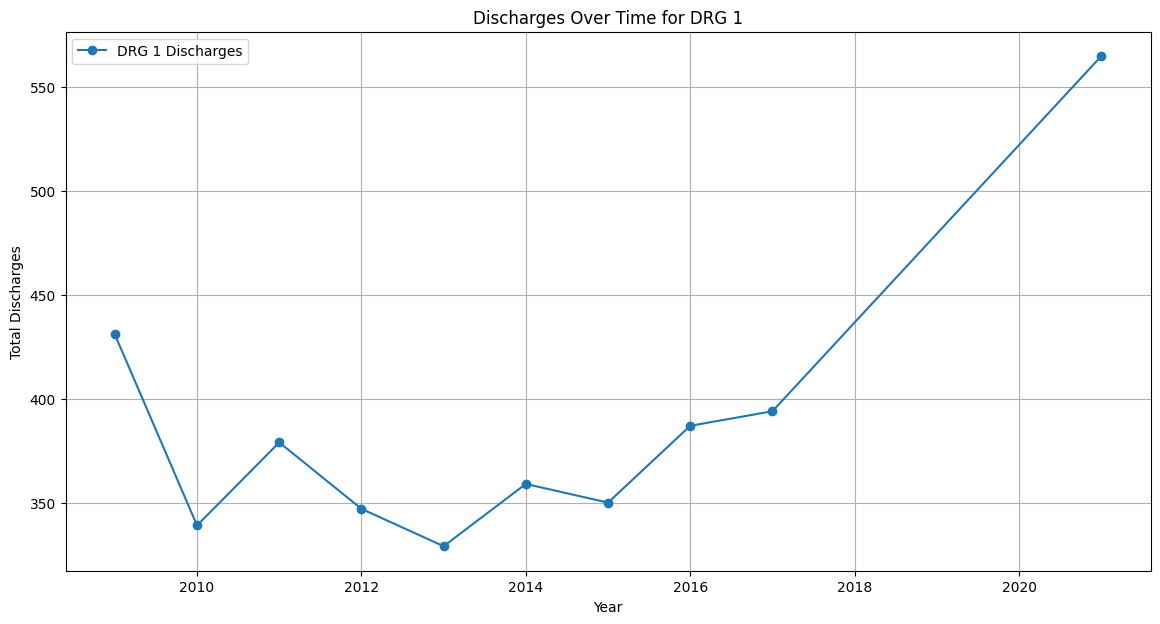

In [86]:
# Plotting charges over time
selected_drg = 1
drg_data = df[df['APR DRG Code'] == selected_drg]

yearly_drg_data = drg_data.groupby('Year')['Discharges'].sum()

plt.figure(figsize=(14, 7))
plt.plot(yearly_drg_data.index, yearly_drg_data.values, marker='o', label=f'DRG {selected_drg} Discharges')
plt.title(f'Discharges Over Time for DRG {selected_drg}')
plt.xlabel('Year')
plt.ylabel('Total Discharges')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
grouped = df.groupby(['Year', 'APR DRG Code']).agg({
    'Discharges': 'sum'
}).reset_index()

actual_vs_predicted = {}

os.makedirs('q2_models', exist_ok=True)

for drg in grouped['APR DRG Code'].unique():
    drg_data = grouped[grouped['APR DRG Code'] == drg].sort_values('Year')
    drg_data.set_index('Year', inplace=True)

    if drg_data.shape[0] >= 10:
        train = drg_data.loc[2009:2016]
        test_actual = drg_data.loc[2017, 'Discharges'] if 2017 in drg_data.index else None

        if test_actual is not None:
            try:
                model = ARIMA(train['Discharges'], order=(1, 1, 1))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=1)
                predicted = forecast.values[0]
                actual_vs_predicted[drg] = (test_actual, predicted)

            except:
                actual_vs_predicted[drg] = (test_actual, None)


results_df = pd.DataFrame.from_dict(actual_vs_predicted, orient='index', columns=['Actual', 'Predicted'])

print(results_df.head(30))
print(f"\nTotal DRGs available: {results_df.shape[0]}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

     Actual     Predicted
1     394.0    346.511088
2     265.0    205.044980
4    4118.0   4158.066948
5    1812.0   2030.871452
6      40.0     47.313437
20   1172.0   1189.397703
21   8554.0   8436.585269
22   1303.0   1445.950310
23   1993.0   4859.608183
24   7151.0   6648.677721
26   1418.0   1926.476565
40   1066.0   1186.423459
41   3627.0   3795.438033
42   6403.0   6229.667497
43   2338.0   2410.824926
44   5264.0   5230.458726
45  25846.0  25764.762002
46    991.0    876.730004
47   7842.0   9167.883001
48   5427.0   5555.777187
49    939.0    932.275400
50   1306.0    926.065267
51    679.0   1051.486977
52   5897.0   5252.825245
53  25766.0  25740.101159
54   4769.0   5121.560814
55   6842.0   6322.321892
56    173.0    -54.183377
57   2320.0   2380.800887
58  17842.0  18973.118036

Total DRGs available: 292


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base

<Figure size 1400x600 with 0 Axes>

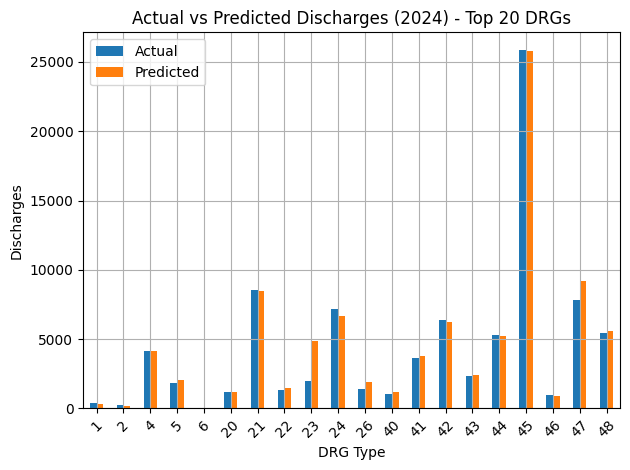

In [77]:
results_df = results_df.dropna()

results_df = results_df.reset_index().rename(columns={'index': 'DRG'})

results_df['Actual'] = pd.to_numeric(results_df['Actual'], errors='coerce')
results_df['Predicted'] = pd.to_numeric(results_df['Predicted'], errors='coerce')

results_df = results_df.dropna()

plt.figure(figsize=(14,6))
subset = results_df.head(20)
subset.plot(x='DRG', y=['Actual', 'Predicted'], kind='bar')
plt.title('Actual vs Predicted Discharges (2024) - Top 20 DRGs')
plt.xlabel('DRG Type')
plt.ylabel('Discharges')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
actual = results_df['Actual']
predicted = results_df['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
r2 = r2_score(actual, predicted)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 1904978.58
RMSE: 1380.21
R² Score: 0.9931


In [82]:
# see trend for each DRG
selected_drg = 163

drg_data = grouped[grouped['APR DRG Code'] == selected_drg].sort_values('Year')
drg_data.set_index('Year', inplace=True)

result_original = adfuller(df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

plt.figure(figsize=(14, 7))
plt.plot(drg_data.index, drg_data['Discharges'], label=f'DRG {selected_drg} Discharges')
plt.title(f'Discharges Over Time for DRG {selected_drg}')
plt.xlabel('Year')
plt.ylabel('Number of Discharges')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'adfuller' is not defined